In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# 参数设置
data_path = "./data/ChestXRay"
num_classes = 2
batch_size = 16
epoch_num = 20
learning_rate = 0.001
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


624 images were found. 437 for training and 187 for validation.


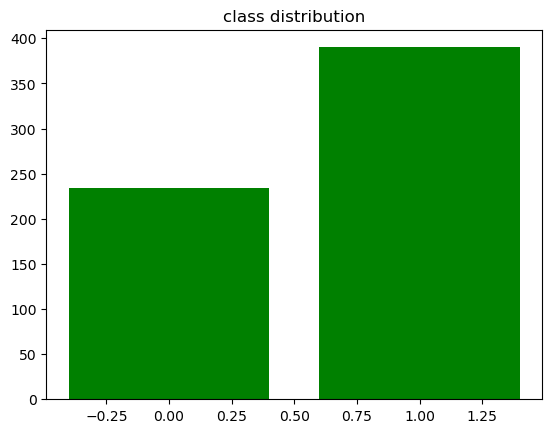

In [3]:
from utils import read_split_data, train_epoch, evaluate
from Mydataset import CustomDataset
from torchvision import transforms
from torch.optim import lr_scheduler
train_data, train_label, val_data, val_label = read_split_data(data_path)

In [4]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}

# instantiate dataset for training and validation
train_dataset = CustomDataset(images_path=train_data,
                          images_class=train_label,
                          transform=data_transform["train"])
val_dataset = CustomDataset(images_path=val_data,
                        images_class=val_label,
                        transform=data_transform["val"])

In [5]:
worker_num = min([os.cpu_count(),batch_size if batch_size>1 else 0, 8])
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=worker_num)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=worker_num)

In [6]:
from ViT import ViT as MyViT

model = MyViT(num_classes=num_classes).to(device)

pg = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(pg,lr=learning_rate)

# Cosine annealing learning rate function
lf = lambda x: ((1 + math.cos(x * math.pi / epoch_num )) / 2) * (1 - 0.001) + 0.001  # cosine
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

In [7]:
for epoch in range(epoch_num):
    train_loss,train_acc = train_epoch(model=model,optimizer=optimizer,data_loader=train_loader,device=device,epoch=epoch)
    scheduler.step()
    val_loss,val_acc = evaluate(model=model,data_loader=val_loader,device=device,epoch=epoch)

[valid epoch 19] loss: 0.574, acc: 0.722: 100%|████████████████████████████████████████| 12/12 [01:13<00:00,  6.09s/it]


In [8]:
# save models
name = "ViT_for_chest"
torch.save(model.state_dict(),f"./models/{name}.pth")

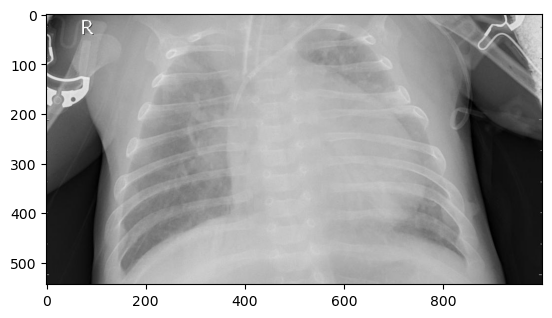

In [11]:
# prediction
from PIL import Image
device = "cpu"
img_path = "./data/samples/virus.jpg"
model_path = './models/ViT_for_chest.pth'
img = Image.open(img_path).convert('RGB')
plt.imshow(img)
data_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
img = data_transform(img)
img = torch.unsqueeze(img, dim=0)

model = MyViT(num_classes=2).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

class: normal       prob: 0.123
class: pneumonia    prob: 0.877


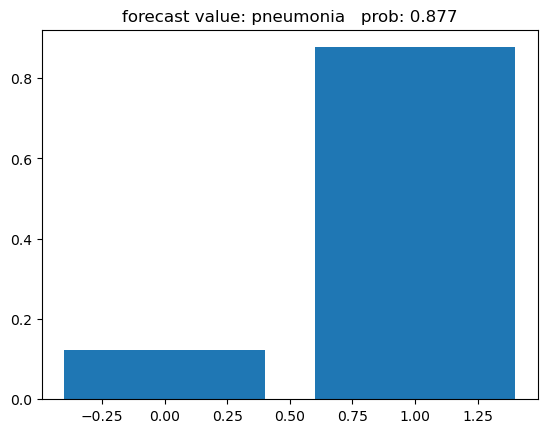

In [12]:
Dict = {"0":"normal","1":"pneumonia"}

print_res = "forecast value: {}   prob: {:.3}".format(Dict[str(predict_cla)],predict[predict_cla].numpy())
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(Dict[str(i)],predict[i].numpy()))
plt.title(print_res)
plt.bar(range(len(predict)),predict)
plt.show()